# Supervised Contrastive Learning

**Author:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date created:** 2020/11/30<br>
**Last modified:** 2020/11/30<br>
**Description:** Using supervised contrastive learning for image classification.

## Introduction

[Supervised Contrastive Learning](https://arxiv.org/abs/2004.11362)
(Prannay Khosla et al.) is a training methodology that outperforms
supervised training with crossentropy on classification tasks.

Essentially, training an image classification model with Supervised Contrastive
Learning is performed in two phases:

1. Training an encoder to learn to produce vector representations of input images such
that representations of images in the same class will be more similar compared to
representations of images in different classes.
2. Training a classifier on top of the frozen encoder.

Note that this example requires [TensorFlow Addons](https://www.tensorflow.org/addons), which you can install using the following command:

```python
pip install tensorflow-addons
```

## Setup

In [1]:
!nvidia-smi

Thu Apr  7 08:51:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.89       Driver Version: 465.89       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 29%   38C    P8    14W / 160W |    883MiB /  6144MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [219]:
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

In [15]:
tf.__version__

'2.8.0'

In [16]:
np.__version__

'1.22.3'

In [17]:
tfa.__version__

'0.16.1'

## Prepare the data

In [40]:
data_dir = "train"
batch_size = 32
img_height = 180
img_width = 180
input_shape = (img_height, img_width, 3)

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 10912 files belonging to 8 classes.
Using 8730 files for training.
Found 10912 files belonging to 8 classes.
Using 2182 files for validation.


In [177]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  shuffle=True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=1)

Found 10912 files belonging to 8 classes.
Using 2182 files for validation.


In [22]:
class_names = train_ds.class_names
print(class_names)

['bullet', 'grenade', 'magazine', 'mobile', 'pistol', 'pliers', 'scissors', 'tear_gas']


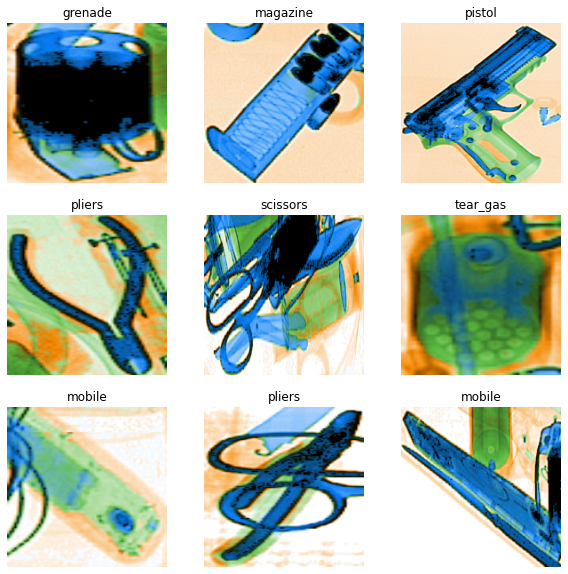

In [23]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [26]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [27]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [30]:
num_classes = len(class_names)
print(num_classes)

8


In [25]:
'''
num_classes = 10
input_shape = (32, 32, 3)

# Load the train and test data splits
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
'''

'\nnum_classes = 10\ninput_shape = (32, 32, 3)\n\n# Load the train and test data splits\n(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()\n\n# Display shapes of train and test datasets\nprint(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")\nprint(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")\n'

## Using image data augmentation

In [38]:
data_augmentation = keras.Sequential(
    [
        # layers.UpSampling2D(size=(3, 3)),
        # layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.02),
        layers.RandomWidth(0.2),
        layers.RandomHeight(0.2),
    ]
)

# Setting the state of the normalization layer.
# data_augmentation.layers[1].adapt(train_ds)

## Build the encoder model

The encoder model takes the image as input and turns it into a 2048-dimensional
feature vector.

In [41]:
def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=(180,180,3), pooling="max"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = resnet(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs, name="BS-encoder")
    return model


encoder = create_encoder()
encoder.summary()

learning_rate = 0.001
# batch_size = 8
hidden_units = 512
projection_units = 128
num_epochs = 50
dropout_rate = 0.5
temperature = 0.05

Model: "BS-encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 180, 180)          0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
Total params: 23,564,800
Trainable params: 23,519,360
Non-trainable params: 45,440
_________________________________________________________________


## Build the classification model

The classification model adds a fully-connected layer on top of the encoder,
plus a softmax layer with the target classes.

In [42]:
def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="cifar10-classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
    )
    return model


## Experiment 1: Train the baseline classification model

In this experiment, a baseline classifier is trained as usual, i.e., the
encoder and the classifier parts are trained together as a single model
to minimize the crossentropy loss.

In [45]:
encoder = create_encoder()
classifier = create_classifier(encoder)
classifier.summary()

history = classifier.fit(x=train_ds, batch_size=batch_size, epochs=num_epochs)




Model: "cifar10-classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 BS-encoder (Functional)     (None, 2048)              23564800  
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24,617,992
Trainable params: 24,57

NameError: name 'x_test' is not defined

In [47]:
accuracy = classifier.evaluate(val_ds)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

69/69 [==============================] - 12s 136ms/step - loss: 0.3927 - sparse_categorical_accuracy: 0.8955
Test accuracy: 89.55%


## Experiment 2: Use supervised contrastive learning

In this experiment, the model is trained in two phases. In the first phase,
the encoder is pretrained to optimize the supervised contrastive loss,
described in [Prannay Khosla et al.](https://arxiv.org/abs/2004.11362).

In the second phase, the classifier is trained using the trained encoder with
its weights freezed; only the weights of fully-connected layers with the
softmax are optimized.

### 1. Supervised contrastive learning loss function

In [48]:
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="BS-encoder_with_projection-head"
    )
    return model


### 2. Pretrain the encoder

In [50]:
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

history = encoder_with_projection_head.fit(
    train_ds, validation_data=val_ds, batch_size=batch_size, epochs=num_epochs
)

Model: "cifar-encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 BS-encoder (Functional)     (None, 2048)              23564800  
                                                                 
 dense_7 (Dense)             (None, 128)               262272    
                                                                 
Total params: 23,827,072
Trainable params: 23,781,632
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/50
273/273 [==============================] - 58s 199ms/step - loss: 2.9504 - val_loss: 3.4943
Epoch 2/50
273/273 [==============================] - 54s 198ms/step - loss: 2.5842 - val_loss: 2.8016
Epoch 3/50
273/273 [==============================] - 55s 202ms/step - lo

### 3. Train the classifier with the frozen encoder

In [60]:
classifier = create_classifier(encoder, trainable=False)

history = classifier.fit(x=train_ds, batch_size=batch_size, epochs=num_epochs)

val_loss, accuracy = classifier.evaluate(val_ds)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test loss: {round(val_loss * 100, 2)}%")

Epoch 1/50
273/273 [==============================] - 18s 59ms/step - loss: 0.5955 - sparse_categorical_accuracy: 0.8632
Epoch 2/50
273/273 [==============================] - 16s 59ms/step - loss: 0.2213 - sparse_categorical_accuracy: 0.9298
Epoch 3/50
273/273 [==============================] - 16s 59ms/step - loss: 0.1862 - sparse_categorical_accuracy: 0.9443
Epoch 4/50
273/273 [==============================] - 16s 59ms/step - loss: 0.1611 - sparse_categorical_accuracy: 0.9498
Epoch 5/50
273/273 [==============================] - 16s 59ms/step - loss: 0.1570 - sparse_categorical_accuracy: 0.9512
Epoch 6/50
273/273 [==============================] - 16s 58ms/step - loss: 0.1486 - sparse_categorical_accuracy: 0.9522
Epoch 7/50
273/273 [==============================] - 16s 58ms/step - loss: 0.1406 - sparse_categorical_accuracy: 0.9560
Epoch 8/50
273/273 [==============================] - 16s 58ms/step - loss: 0.1417 - sparse_categorical_accuracy: 0.9560
Epoch 9/50
273/273 [============

In [68]:
history = classifier.fit_generator(train_ds, epochs=num_epochs)

Epoch 1/50
  1/273 [..............................] - ETA: 33s - loss: 0.0085 - sparse_categorical_accuracy: 1.0000

C:\Program Files\KMSpico\temp\ipykernel_4564\2223895399.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = classifier.fit_generator(train_ds, epochs=num_epochs)


273/273 [==============================] - 16s 59ms/step - loss: 0.0959 - sparse_categorical_accuracy: 0.9734
Epoch 2/50
 63/273 [=====>........................] - ETA: 12s - loss: 0.0816 - sparse_categorical_accuracy: 0.9742

KeyboardInterrupt: 

In [55]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy'])

ValueError: x and y must have same first dimension, but have shapes (50,) and (1,)

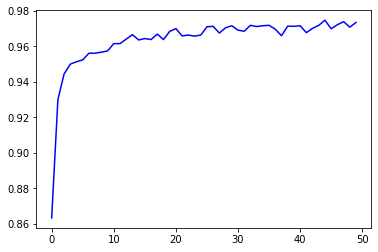

In [63]:
acc = history.history['sparse_categorical_accuracy']
val_acc = accuracy
loss = history.history['loss']
# val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [133]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [141]:
validation_generator = test_datagen.flow_from_directory(data_dir,
                                                        batch_size=1,
                                                        class_mode='categorical')

Found 10912 images belonging to 8 classes.


In [136]:
validation_generator.classes.__len__()

10912

In [183]:
for i in range(len(val_ds)):
    class_ = next(iter(val_ds))[1].numpy()
    gt.append(class_[0])
    

In [184]:
len(gt)

2182

In [186]:
gt_img = []

In [187]:
for i in range(len(val_ds)):
    img_tuple = next(iter(val_ds))[0].numpy()
    gt_img.append(img_tuple)
    

In [188]:
len(gt_img)

2182

In [189]:
gt_img[0].shape

(1, 180, 180, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


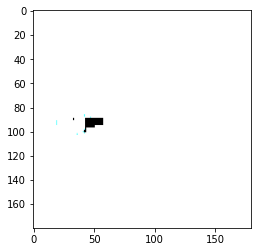

In [163]:
plt.imshow(gt_img[0][0])
plt.show()

In [212]:
gt = []

In [213]:
y_pred = []

In [214]:
for img, label in val_ds:
    Y_pred = classifier.predict(img)
    y_pred.append(Y_pred.argmax(axis=1)[0])
    gt.append(label.numpy()[0])

In [215]:
y_pred[:10]

[0, 1, 7, 5, 4, 1, 1, 5, 4, 0]

In [216]:
gt[:10]

[0, 1, 7, 5, 4, 1, 1, 5, 4, 0]

In [143]:
#Confution Matrix and Classification Report
# num_of_test_samples=2182
Y_pred = classifier.predict(gt1[0].numpy())
y_pred = Y_pred.argmax(axis=-1)
# y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names =['bullet','grenade','magazine','mobile','pistol','pliers','scissors','tear_gas'][::-1]
print(classification_report(validation_generator.classes, y_pred, target_names=class_names))

Confusion Matrix


ValueError: Found input variables with inconsistent numbers of samples: [10912, 1]

In [217]:
print('Confusion Matrix')
print(confusion_matrix(gt, y_pred))
print('Classification Report')
target_names =['bullet','grenade','magazine','mobile','pistol','pliers','scissors','tear_gas']
print(classification_report(gt, y_pred, target_names=target_names))

Confusion Matrix
[[127   0   0   0   0   1   1   0]
 [  0 323   1   0   0   1  12   0]
 [  0   2 148   0   2   2   1   0]
 [  0   0   1 205   5   6   7   5]
 [  0   0   0   0 248   0   0   0]
 [  0   1   0   1  13 338   7   0]
 [  0   0   0   2   1   7 500   0]
 [  0   2   1   5   2   5   5 194]]
Classification Report
              precision    recall  f1-score   support

      bullet       1.00      0.98      0.99       129
     grenade       0.98      0.96      0.97       337
    magazine       0.98      0.95      0.97       155
      mobile       0.96      0.90      0.93       229
      pistol       0.92      1.00      0.96       248
      pliers       0.94      0.94      0.94       360
    scissors       0.94      0.98      0.96       510
    tear_gas       0.97      0.91      0.94       214

    accuracy                           0.95      2182
   macro avg       0.96      0.95      0.96      2182
weighted avg       0.96      0.95      0.95      2182



In [77]:
y_pred

array([1, 0, 1, ..., 7, 6, 1], dtype=int64)

In [ ]:
true_classes = test_generator.classes
class_indices = test_generator.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

In [55]:
true_classes;

In [56]:
scratch_preds = model.predict(test_generator)
scratch_pred_classes = np.argmax(scratch_preds, axis=1)

In [57]:

from sklearn.metrics import confusion_matrix

In [58]:
class_names =  test_generator.class_indices.keys()

In [59]:
scratch_pred_classes

array([2, 4, 3, ..., 4, 7, 7], dtype=int64)

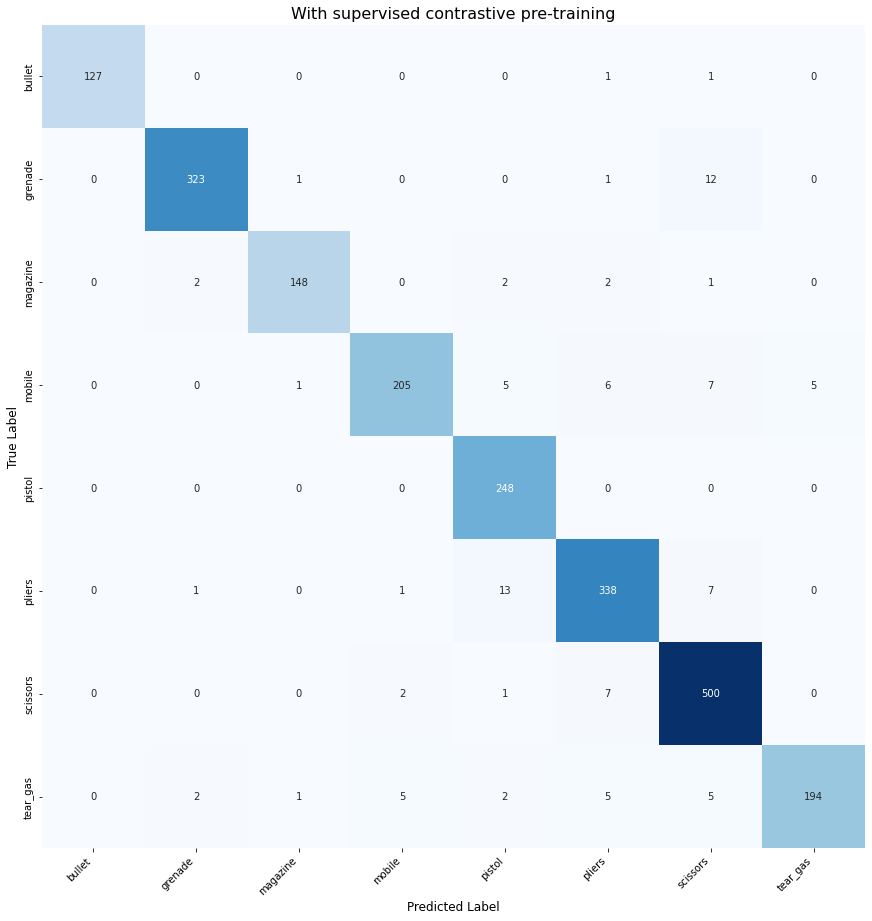

In [220]:
def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        square=True, 
        xticklabels=class_names, 
        yticklabels=class_names,
        fmt='d', 
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax
    )
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=12)

fig, (ax1) = plt.subplots(1, 1, figsize=(20, 10))

plot_heatmap(gt, y_pred, class_names, ax1, title="With supervised contrastive pre-training")  
#fig.suptitle("Confusion Matrix Model Comparison", fontsize=24)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()

## Conclusion

As shown in the experiments, using the supervised contrastive learning technique
outperformed the conventional technique in terms of the test accuracy. Note that
the same training budget (i.e., number of epochs) was given to each technique.
Supervised contrastive learning pays off when the encoder involves a complex
architecture, like ResNet, and multi-class problems with many labels.
In addition, large batch sizes and multi-layer projection heads
improve its effectiveness. See the [Supervised Contrastive Learning](https://arxiv.org/abs/2004.11362)
paper for more details.

You can use the trained model hosted on [Hugging Face Hub](https://huggingface.co/keras-io/supervised-contrastive-learning-cifar10) and try the demo on [Hugging Face Spaces](https://huggingface.co/spaces/keras-io/supervised-contrastive-learning).